## Voltage ramp benchmarking
This notebook looks at various components of a standard QT fridge setup to identify which component sets the bottleneck for ramping voltages and gives some idea of what those ramp rate limits are.  Notebook uses a Keysight MSOS254A scope and Rigol DG1062 function generator.

In [1]:
%matplotlib notebook
import qcodes as qc
import numpy as np
from matplotlib import pyplot as plt
import sys
import time

In [2]:
from qcodes.instrument_drivers.Keysight.Infiniium import Infiniium
from qcodes.instrument_drivers.rigol.DG1062 import DG1062

station = qc.Station()
mso = Infiniium("mso",  address="TCPIP0::169.254.45.211")
rigol =  DG1062("rigol", address='TCPIP0::169.254.187.99')
station.add_component(mso)
station.add_component(rigol)

Connected to: KEYSIGHT TECHNOLOGIES MSOS254A (serial:MY57480103, firmware:06.10.00803) in 0.18s
Connected to: Rigol Technologies DG1062Z (serial:DG1ZA195006397, firmware:03.01.12) in 0.03s


e:\code\qcodes\qcodes\instrument\parameter.py:245: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '
Snapshot: Could not update parameter: period on rigol_burst
Snapshot: Could not update parameter: period on rigol_burst


'rigol'

In [6]:
sys.path.append(r'E:/Code')
from StationQ.MDAC.Driver.MDAC import MDAC

mdac = MDAC('mdac', address='ASRL4::INSTR')
station.add_component(mdac)

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\ctwrapper\functions.py:1649: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x303035313535510D0032001D, firmware:1.4) in 5.02s


'mdac'

## Configure the scope

In [4]:
for i in range(4):
    mso.channels[i].display(False)
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

In [5]:
mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

In [6]:
nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

## Setup Rigol function generator

In [6]:
rigol.ch1.impedance('HighZ')
rigol.ch1.ramp(freq=500, ampl=1, offset=0.5, phase=0) #freq, ampl, offset, phase

DataSet:
   location = 'data/2018-09-10/#002_{name}_16-27-30'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-09-10 16:27:33


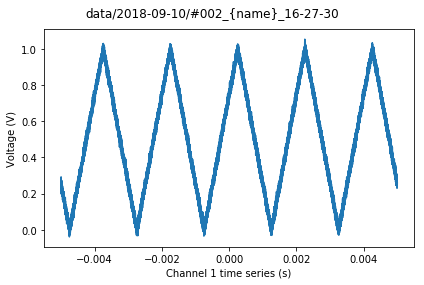

In [8]:
mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

This matches what is on the front panel, and (not surprisingly) there is no distortion for a 500Hz triangle wave when the function generator is connected to the scope by a 4' long BNC cable

## Impact of room temperature cabling
Connect the function generator to a Sydney breakout box via a 4' BNC cable then connect the breakout box to a second breakout box via 3m micro-D cable (with twisted pairs) and then via 4' BNC cable to scope

DataSet:
   location = 'data/2018-08-28/#002_{name}_13-26-45'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-28 13:26:48


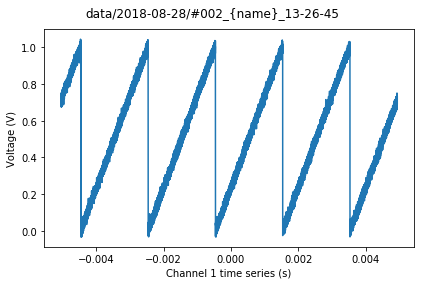

In [26]:
mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

No appreciable change

Try increasing the frequency until things do start to round off

In [30]:
rigol.ch1.ramp(freq=500000, ampl=1, offset=0.5, phase=0)

In [66]:
# for i in range(4):
#     mso.channels[i].display(False)
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

In [67]:
mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

In [68]:
nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

DataSet:
   location = 'data/2018-08-28/#006_{name}_13-48-29'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-28 13:48:31


<IPython.core.display.Javascript object>


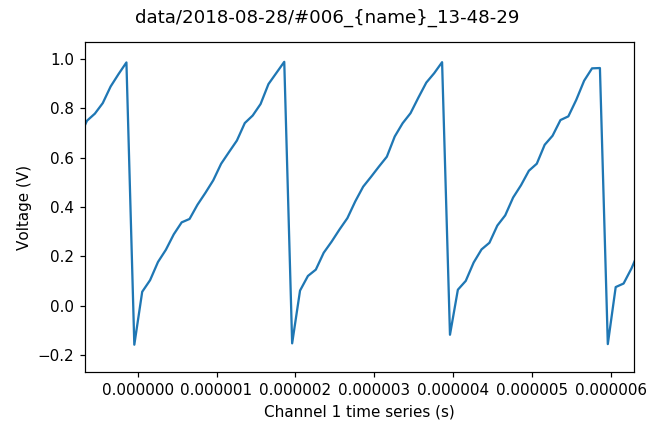

In [72]:
%matplotlib notebook
mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

Even a 500kHz ramp seems more or less unaffected by the micro-D cables and breakout box

## Add QDevil filter
Repeat the previous test but add a QDevil RC filter inline

In [73]:
#Back to 500Hz ramp
rigol.ch1.ramp(freq=500, ampl=1, offset=0.5, phase=0)

DataSet:
   location = 'data/2018-08-28/#007_{name}_15-04-17'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-28 15:04:19


<IPython.core.display.Javascript object>


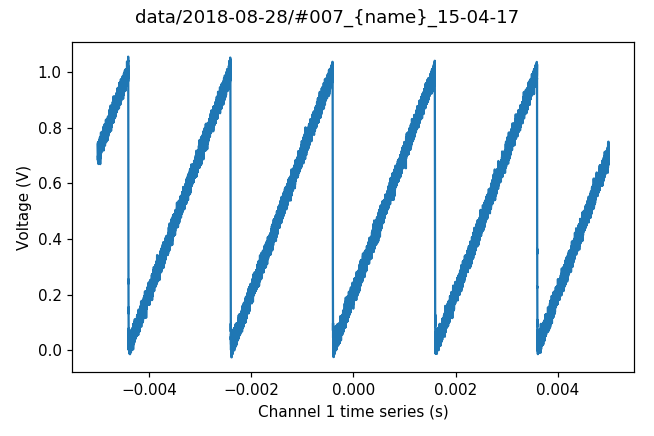

In [74]:
mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

Once again no rounding of the ramp.  Try going to higher frequency again.

In [77]:
rigol.ch1.ramp(freq=50000, ampl=1, offset=0.5, phase=0)

DataSet:
   location = 'data/2018-08-29/#001_{name}_13-53-20'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-29 13:53:22


<IPython.core.display.Javascript object>


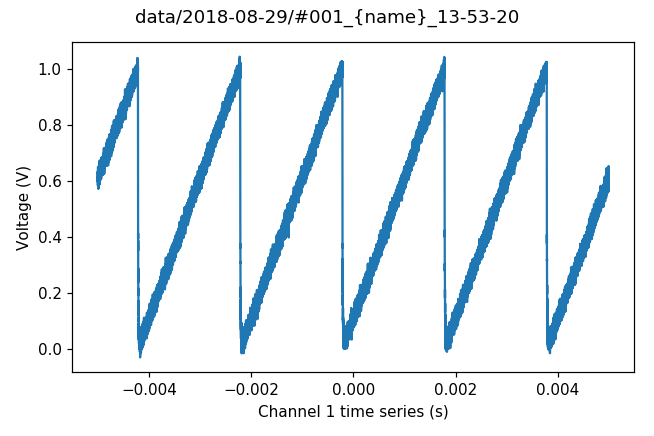

In [85]:
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

Now we see considerable rounding and attenuation at 50kHz ramp frequency which is expected (from datasheet, should expect 3dB point ~50kHz).  You'll have to trust me on this - I mistakenly executed this cell again after changing the setup...

## Add probe and flex PCB
Add (inline) one of the QT fridge bottom loading probes with the flex PCB plugged in to the top of the probe and the 100-pin Micro-D connector on the flex PCB plugged in to a shorting plug.  In other words, the signal from the function generator travels through a BNC cable, breakout box, 3m micro-D cable, QDevil filter, up the probe, through the flex PCB, back into the probe, through a second 3m micro-D cable, back into the breakout box, then through one final BNC cable to the scope.  The probe should give a rough approximation of the impact of the wiring inside the fridge since it is made of similar twisted pairs and thermalization bobbins.

In [83]:
rigol.ch1.ramp(freq=500, ampl=1, offset=0.5, phase=0)

DataSet:
   location = 'data/2018-08-29/#002_{name}_13-53-41'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-29 13:53:44


<IPython.core.display.Javascript object>


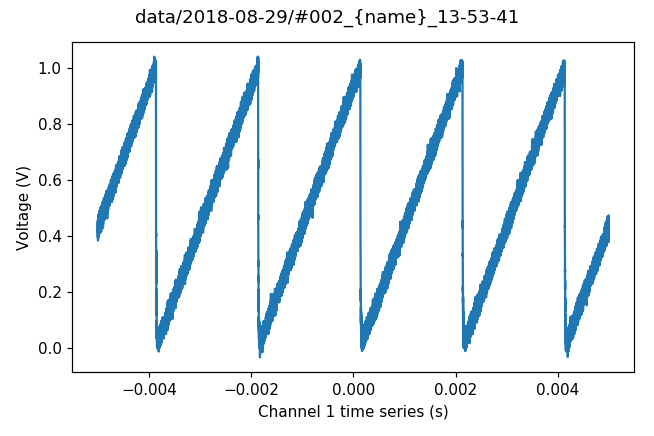

In [86]:
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

Everything still looks fine for a 500Hz ramp.  Try increasing until rounding occurs again.

In [87]:
rigol.ch1.ramp(freq=5000, ampl=1, offset=0.5, phase=0)

DataSet:
   location = 'data/2018-08-29/#003_{name}_13-54-42'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-29 13:54:45


<IPython.core.display.Javascript object>


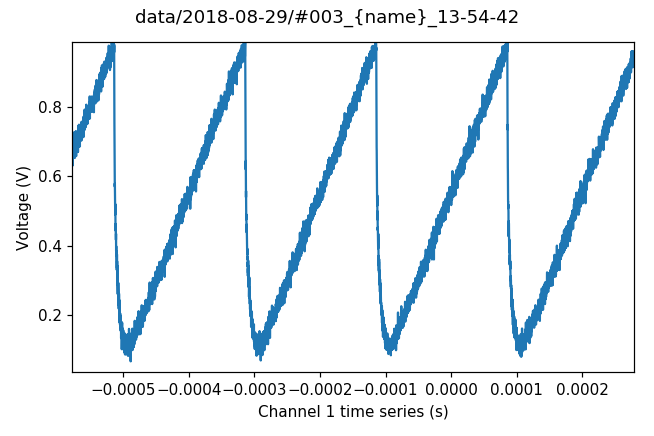

In [88]:
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

5kHz looks ok.

In [89]:
rigol.ch1.ramp(freq=50000, ampl=1, offset=0.5, phase=0)

DataSet:
   location = 'data/2018-08-29/#004_{name}_13-55-35'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-29 13:55:37


<IPython.core.display.Javascript object>


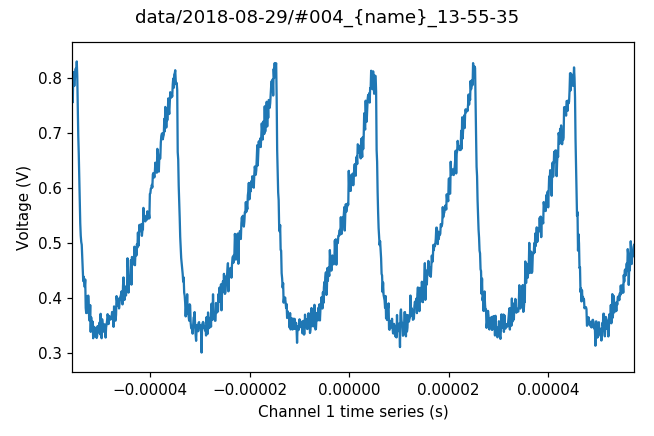

In [90]:
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

At 500kHz we see considerable rounding again.

## Add motherboard
Add a Gen5.0 motherboard with the diagnostic daughterboard (e.g. pairs of DC lines shorted together) inline to the previous chain.  This should give a reasonable approximation of the entire DC signal chain in an actual experiment

In [97]:
rigol.ch1.ramp(freq=500, ampl=1, offset=0.5, phase=0)

DataSet:
   location = 'data/2018-08-29/#007_{name}_14-55-26'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-29 14:55:28


<IPython.core.display.Javascript object>


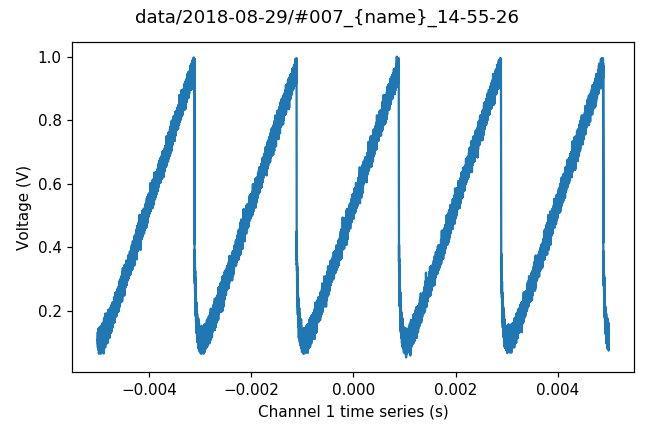

In [98]:
mso.ch1.display(True)
mso.timebase_range(10e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

There is obviously some rounding here already at 500Hz.  Lowest bit of blue in the plot above ~67mV, center of noise at bottom of ramp ~ 120mV.  Try at 100Hz (e.g. what was used for the first phase diagram measurement)

In [105]:
rigol.ch1.ramp(freq=100, ampl=1, offset=0.5, phase=0)

DataSet:
   location = 'data/2018-08-29/#011_{name}_14-58-59'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-08-29 14:59:02


<IPython.core.display.Javascript object>


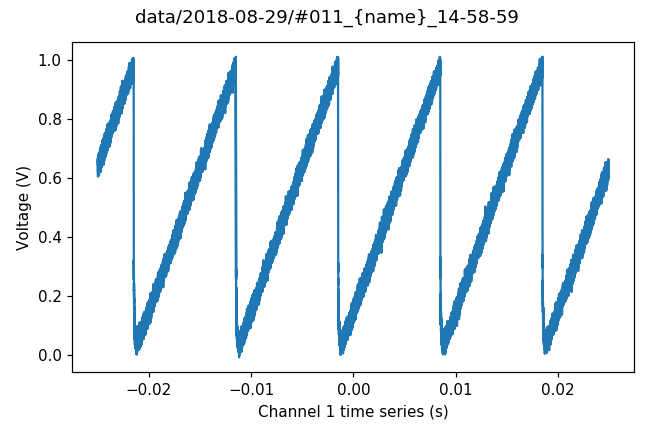

In [107]:
mso.ch1.display(True)
mso.timebase_range(50e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

mso.trigger_enabled(True)
mso.trigger_edge_source('CHANnel1')
mso.trigger_edge_slope('positive')
mso.ch1.trigger_level(0.15)

nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

mso.ch1.trace.prepare_curvedata()
data = mso.ch1.trace
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

Center of noise at bottom of ramp ~ 47mV.  Roughly speaking, this looks like 100Hz is about as fast as one should ramp with the Gen5.0 motherboards in their standard configuration

## Try with MDAC

In [7]:
def safe_mode(*channels):
    for ch in channels:
        #ch.awg_off()
        ch.voltage(0)
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        ch.bus('open')
        ch.dac_output('open')
        
def prepare_channels(*channels):
    '''
    Prepare for smc use
    '''
    for ch in channels:
        #ch.awg_off()
        ch.voltage(0)
        ch.gnd('open')
        ch.smc('close')
        ch.microd('open')
        ch.bus('open')
        ch.dac_output('close')

In [8]:
ch1 = mdac.ch01
ch2 = mdac.ch02
safe_mode(ch1,ch2)

In [9]:
prepare_channels(ch1,ch2)

### One-channel ramp

In [29]:
ch1.awg_sawtooth(50,1,offset=0.5)

mso.ch1.display(True)
mso.timebase_range(50e-3)
mso.timebase_position(0)
mso.ch1.range(4)
mso.ch1.offset(0)

nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

DataSet:
   location = 'data/2018-09-12/#006_{name}_09-53-07'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
acquired at 2018-09-12 09:53:11


<IPython.core.display.Javascript object>


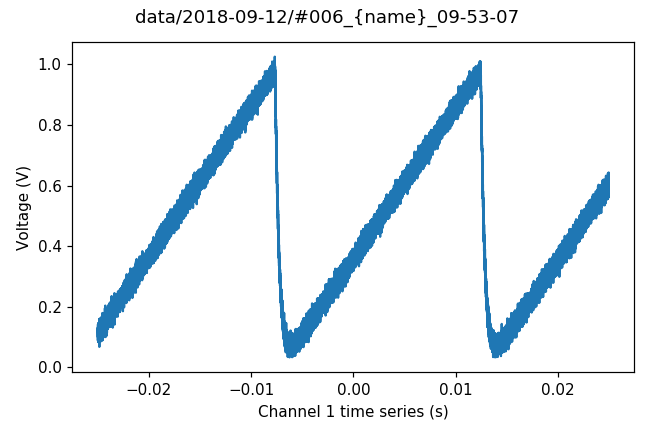

In [30]:
mso.ch1.trace.prepare_curvedata()
data = qc.Measure(mso.ch1.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])

ch1.awg_off()

In [30]:
data.arrays['mso_chan1_trace'].min()

0.032594727299999994

### Two-channel ramp

In [101]:
ch1.awg_sawtooth(50,1,offset=0.5)
ch2.awg_sawtooth(50,1,offset=0.5)

mso.timebase_range(50e-3)
mso.timebase_position(0)
mso.ch2.display(True)
mso.ch2.range(4)
mso.ch2.offset(0)
mso.ch1.display(True)
mso.ch1.range(4)
mso.ch1.offset(0)

nPoints = 100000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

DataSet:
   location = 'data/2018-09-12/#017_{name}_10-33-47'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | mso_chan1_trace | trace        | (100000,)
   Measured | mso_chan2_trace | trace        | (100000,)
acquired at 2018-09-12 10:33:55


<IPython.core.display.Javascript object>


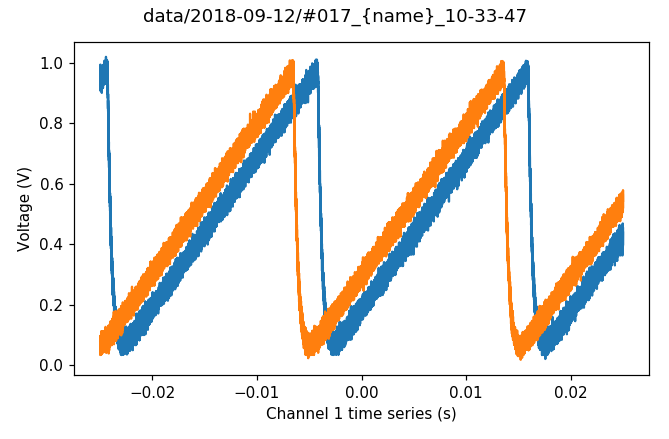

In [69]:
mso.ch1.trace.prepare_curvedata()
mso.ch2.trace.prepare_curvedata()

data = qc.Measure(mso.ch1.trace,mso.ch2.trace).run()
plot = qc.MatPlot(data.arrays['mso_chan1_trace'])
plot.add(data.arrays['mso_chan2_trace'])

ch1.awg_off()
ch2.awg_off()

In [96]:
ch6 = mdac.ch06
safe_mode(ch6)
prepare_channels(ch6)

In [97]:
ch6.awg_sine(50, 0.5, 0.25)

## Tests

In [10]:
mso.timebase_range(1)
mso.timebase_position(0.25)

mso.ch2.display(True)
mso.ch2.range(4)
mso.ch2.offset(0)
mso.ch1.display(True)
mso.ch1.range(4)
mso.ch1.offset(0)
mso.ch3.display(True)
mso.ch3.range(4)
mso.ch3.offset(0)

nPoints = 10000;
mso.acquire_points(nPoints)
mso.acquire_sample_rate(nPoints/mso.timebase_range())

In [11]:
ch1 = mdac.ch01
ch2 = mdac.ch02
safe_mode(ch1,ch2)
prepare_channels(ch1,ch2)

In [19]:
ch2.awg_sawtooth(100,1,offset=0.5)
ch1.awg_sawtooth(50,1,offset=0.5)
time.sleep(1)
mdac.stop()

MDAC:0: UserWarning: ERROR: 0x000A, (PARSE_CMD_BAD_SLAVE_RELAY)
MDAC:0: UserWarning: ERROR: 0x002C, (PARSE_CMD_COMBO_CMD_ERR)


In [18]:
time.sleep(10)
#ch2.awg_sawtooth(100,1,offset=0.5)
#ch1.awg_sawtooth(100,1,offset=0.5)
time.sleep(0.1)
mdac.stop()
time.sleep(0.1)
mdac.run()
time.sleep(0.1)
mdac.stop()

In [15]:
mdac.run()

In [10]:
ch1.waveform()

'dc'

In [27]:
time.sleep(10)
mdac.run()
mdac.stop()
mdac.run()

In [14]:
mdac.stop()

In [23]:
ch1.frequency(50)

In [20]:
time.sleep(0.01)
ch1.awg_off()
ch2.awg_off()
prepare_channels(ch1,ch2)

MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x002C, (PARSE_CMD_COMBO_CMD_ERR)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x002C, (PARSE_CMD_COMBO_CMD_ERR)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)


In [85]:
ch6.awg_off()

In [106]:
import time
time.sleep(10)
#ch2.awg_sawtooth(50,1,offset=0.5)
mdac.ch06.voltage(0.1)

In [143]:
mdac.list_triggers()

(1, 9, 17, 25, 33, 41, 49, 57)

In [142]:
mdac.ch01.attach_trigger()

In [20]:
ch1.voltage()

0.3574946

In [151]:
mdac.sync()

In [155]:
time.sleep(10)
mdac.run()

In [55]:
ch1.autosync()

True

In [60]:
mdac.ch01.awg_off()

In [69]:
safe_mode(ch1,ch2)

In [10]:
time.sleep(5)
mdac.stop()


In [15]:
mdac.run()

In [18]:
mdac.stop()

In [19]:
ch1.waveform()
#ch1.frequency()
#ch1.offset()

MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)


''

In [30]:
ch2.awg_off()

MDAC:0: UserWarning: ERROR: 0x000A, (PARSE_CMD_BAD_SLAVE_RELAY)
MDAC:0: UserWarning: ERROR: 0x002C, (PARSE_CMD_COMBO_CMD_ERR)


In [30]:
safe_mode(ch1,ch2)

MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
MDAC:0: UserWarning: ERROR: 0x0002, (PARSE_CMD_FATAL_ERR_RECOVERY)
